<a href="https://colab.research.google.com/github/IsinghGitHub/DAT210x/blob/master/Language_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# DataFrame
import pandas as pd

In [0]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D)

In [0]:
#LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [0]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [0]:
# Word2vec
import gensim


In [0]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [0]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [52]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Settings

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


## Dataset details
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

## Accessing file from OS 

In [0]:
import os, sys

# Open a file
#path = "E:\\Documents\\Data_Science\\Analytics_vidya\\Sentiment_Analysis_Tweets\\tweeter_training_data"
#dirs = os.listdir( path )

# This would print all the files and directories
#for file in dirs:
       #print (file)

In [55]:
from google.colab import drive
drive.mount('/content/tweeter_data')


Drive already mounted at /content/tweeter_data; to attempt to forcibly remount, call drive.mount("/content/tweeter_data", force_remount=True).


In [0]:
import os
import gc
#os.chdir('E:/')
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [57]:
#Change the working directory
os.chdir('/content/tweeter_data/My Drive/Collab_Projects/Sentiment_Analysis_Tweets/tweeter_training_data/')
os.listdir()

['tweeter_dataset_16M.csv']

In [0]:
import pandas as pd
import numpy as np
import math
import nltk
import re 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import tensorflow as tf
from tensorflow.keras import backend as backend
import codecs
tf.set_random_seed(42)

In [59]:
with codecs.open('tweeter_dataset_16M.csv', encoding=DATASET_ENCODING) as f:
    texual_data = f.read()
texual_data[0:200]

'"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D"\n"0","'

In [0]:
from google.colab import files

df = pd.read_csv('tweeter_dataset_16M.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)


In [0]:
#import os,sys
#path = 'E:\\Documents\\Data_Science\\Analytics_vidya\\Sentiment_Analysis_Tweets\\tweeter_training_data\\'
#dataset_filename = os.listdir(path)[0]
#path
#dataset_filename

In [0]:
#dataset_path = os.path.join(path,dataset_filename)

In [0]:
#df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [64]:
print("Dataset size:", len(df))

Dataset size: 1600000


## Map target label to String
0 -> NEGATIVE
2 -> NEUTRAL
4 -> POSITIVE

In [0]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [66]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 682 ms, sys: 5.17 ms, total: 687 ms
Wall time: 697 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

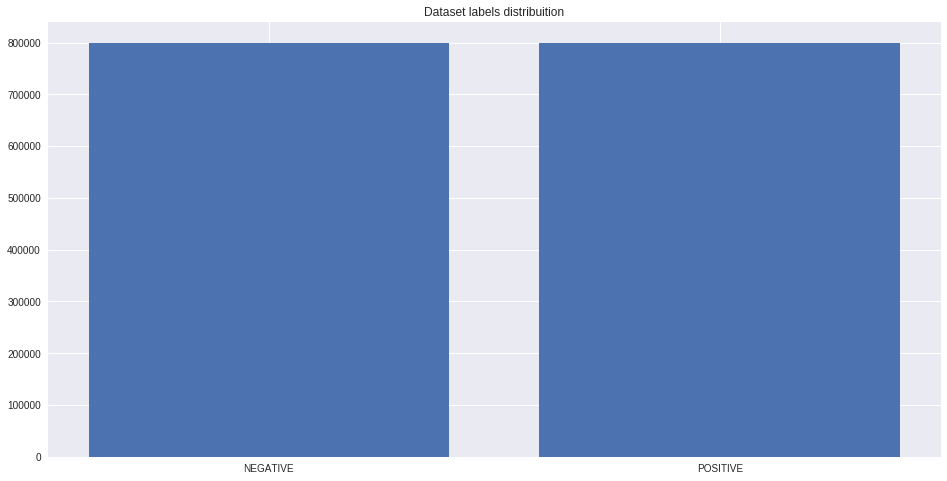

In [67]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Pre-Process dataset

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [70]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 49.3 s, sys: 129 ms, total: 49.4 s
Wall time: 49.5 s


## Split train and test

In [71]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


## Word2Vec

In [72]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.4 s, sys: 303 ms, total: 3.7 s
Wall time: 3.71 s


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [74]:
w2v_model.build_vocab(documents)

2019-02-21 10:23:25,685 : INFO : collecting all words and their counts
2019-02-21 10:23:25,688 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-21 10:23:25,720 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-02-21 10:23:25,747 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-02-21 10:23:25,773 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-02-21 10:23:25,799 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-02-21 10:23:25,825 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-02-21 10:23:25,852 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-02-21 10:23:25,880 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-02-21 10:23:25,908 : INFO : PROGRESS: at s

In [75]:
words  = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [76]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-02-21 10:23:30,167 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-02-21 10:23:31,290 : INFO : EPOCH 1 - PROGRESS: at 4.45% examples, 331976 words/s, in_qsize 13, out_qsize 2
2019-02-21 10:23:32,304 : INFO : EPOCH 1 - PROGRESS: at 9.23% examples, 358184 words/s, in_qsize 14, out_qsize 5
2019-02-21 10:23:33,403 : INFO : EPOCH 1 - PROGRESS: at 14.54% examples, 371606 words/s, in_qsize 15, out_qsize 0
2019-02-21 10:23:34,435 : INFO : EPOCH 1 - PROGRESS: at 19.73% examples, 381985 words/s, in_qsize 16, out_qsize 0
2019-02-21 10:23:35,524 : INFO : EPOCH 1 - PROGRESS: at 24.72% examples, 380900 words/s, in_qsize 16, out_qsize 0
2019-02-21 10:23:36,580 : INFO : EPOCH 1 - PROGRESS: at 29.80% examples, 384148 words/s, in_qsize 14, out_qsize 1
2019-02-21 10:23:37,597 : INFO : EPOCH 1 - PROGRESS: at 34.68% examples, 384949 words/s, in_qsize 14, out_qsize 1
2019-02-21 10:23:38,597 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 21min 50s, sys: 4.82 s, total: 21min 55s
Wall time: 11min 12s


(263123428, 295270528)

In [77]:
w2v_model.most_similar("love")

2019-02-21 10:34:43,153 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5743352174758911),
 ('loves', 0.5617808699607849),
 ('loved', 0.5331576466560364),
 ('adore', 0.5241740942001343),
 ('amazing', 0.5005620718002319),
 ('looove', 0.49606549739837646),
 ('awesome', 0.4657699465751648),
 ('lovee', 0.44312143325805664),
 ('miss', 0.44245004653930664),
 ('loooove', 0.43469715118408203)]

## Tokenize Text

In [78]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 23.6 s, sys: 150 ms, total: 23.8 s
Wall time: 23.7 s


In [79]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 34.7 s, sys: 798 ms, total: 35.5 s
Wall time: 35.5 s


## Label Encoder

In [80]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [81]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [82]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [83]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

## Embedding layer

In [84]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [0]:
combined_embedding_vector_length= embedding_matrix.shape[1]

In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## Build Model

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [92]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


**Compile model**

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Callbacks**

In [0]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

**Train**

In [0]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2019-02-21 11:00:23,399 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
 290816/1152000 [======>.......................] - ETA: 12:33 - loss: 0.5368 - acc: 0.7264